In [1]:
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, cross_val_score
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import graphviz

In [2]:
def train_test_score(max_depth, min_samples_leaf=1, min_samples_split=2):
    np.random.seed(333)
    
    modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, 
                                    min_samples_split=min_samples_split)
    resultados = cross_validate(modelo, x, y, cv=KFold(n_splits=5, shuffle=True), return_train_score=True)
    treino = resultados['train_score'].mean()
    teste = resultados['test_score'].mean()
    
    return treino, teste

In [3]:
# Carregamento dos dados
uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
display(dados.head())

x = dados.drop(columns=['vendido'])
y = dados.vendido

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


# 01. Hiperparâmetros, overfit e otimização

Para observar a influência dos hiperparâmetros (parâmetros definidos antes do treino), será usado o modelo DecisionTreeClassifier, variando 1 hiperparâmetro. Também será possível observar o sobreajuste (overfitting) do modelo sobre os dados de treino conforme aumenta a profundidade da árvore de decisão.

In [4]:
# Iterando por diversos valores de 'max_depth' e salvando os resultados
max_depth = list(range(1, 31))
scores = []
    
for K in max_depth:
    score_K = list(train_test_score(K))
    scores.append(score_K)

In [5]:
# Organizando os resultados em um dataframe, junto dos valores do parâmetro
scores_df = pd.DataFrame(scores, columns=['treino', 'teste'])
scores_df = pd.concat([pd.DataFrame(max_depth, columns=['max_depth']), scores_df], axis=1)
scores_df.head()

,max_depth,treino,teste
0,1,0.757925,0.7578
1,2,0.757925,0.7578
2,3,0.787675,0.7868
3,4,0.788250,0.7855
4,5,0.789675,0.7857


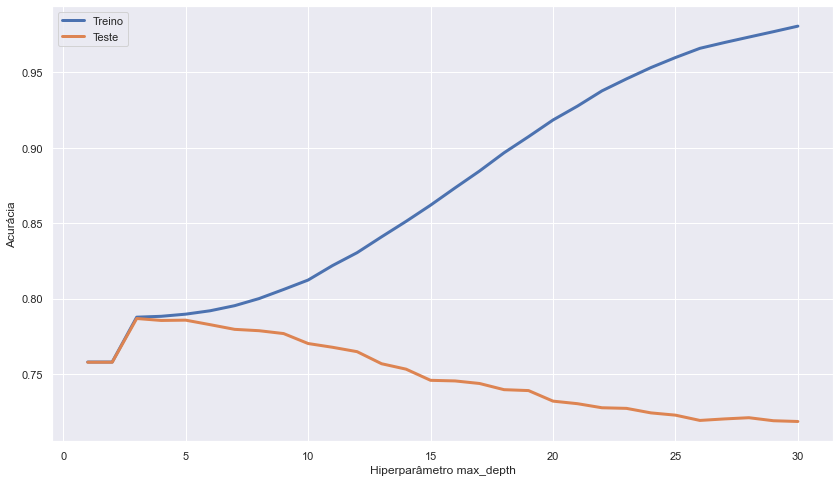

In [6]:
sns.set_theme()
# Visualizando a variação da precisão treino/treste
plt.figure(figsize=(14,8))
sns.lineplot(x=scores_df.max_depth, y=scores_df.treino, linewidth=3)
sns.lineplot(x=scores_df.max_depth, y=scores_df.teste, linewidth=3)

plt.xlabel('Hiperparâmetro max_depth')
plt.ylabel('Acurácia')
plt.legend(['Treino', 'Teste'])

# 02. Explorando 2 dimensões de hiperparâmetros

In [7]:
# Iterando, agora, por 'max_depth' e 'min_samples_leaf', expressado como decimal das linhas da base inicial
max_depth = list(range(1, 31))
min_samples_leaf = np.multiply([0.01, 0.02, 0.04, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                               dados.shape[0]).astype(int)
scores = []

for K in max_depth:
    for J in min_samples_leaf:
        score_K = list(train_test_score(K, J))
        aux = [K, J]
        aux.extend(score_K)
        scores.append(aux)
        # Lista com [max_depth, min_samples_leaf, train_score, test_score]

In [8]:
score_df = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'train_score',  'test_score'])
display(score_df.sort_values(by='test_score', ascending=False).head(10))
# Na matriz de correlação
corr = score_df.corr()

,max_depth,min_samples_leaf,train_score,test_score
19,3,200,0.787550,0.7869
18,3,100,0.787550,0.7869
27,4,100,0.787550,0.7869
28,4,200,0.787550,0.7869
36,5,100,0.787625,0.7862
37,5,200,0.787975,0.7841
54,7,100,0.790475,0.7840
63,8,100,0.791625,0.7839
72,9,100,0.792950,0.7830
135,16,100,0.794150,0.7829


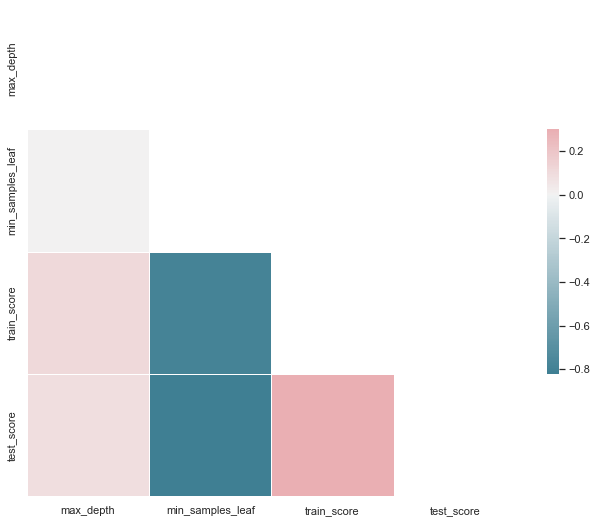

In [9]:
## Usando o código da página https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

O resultado *sugere* que haja uma correlação negativa entre ambos os scores de teste e treino e o parâmetro de min_samples_leaf.

(0.7832499999999999, 0.7824)
(0.7876749999999999, 0.7868)


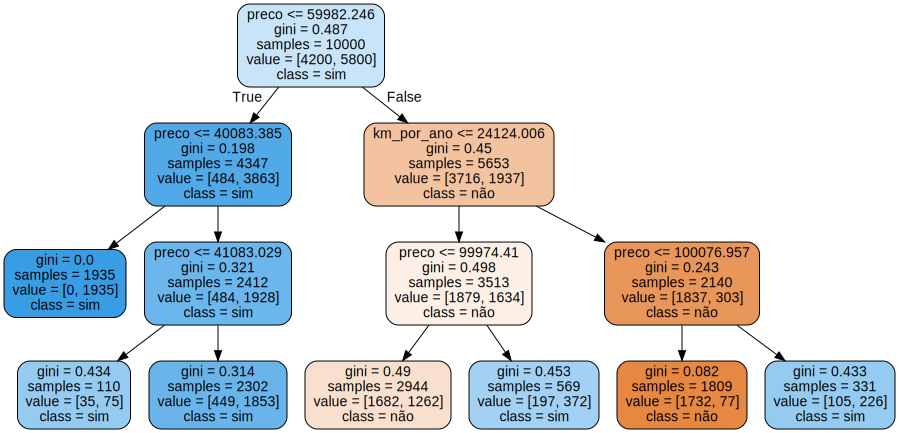

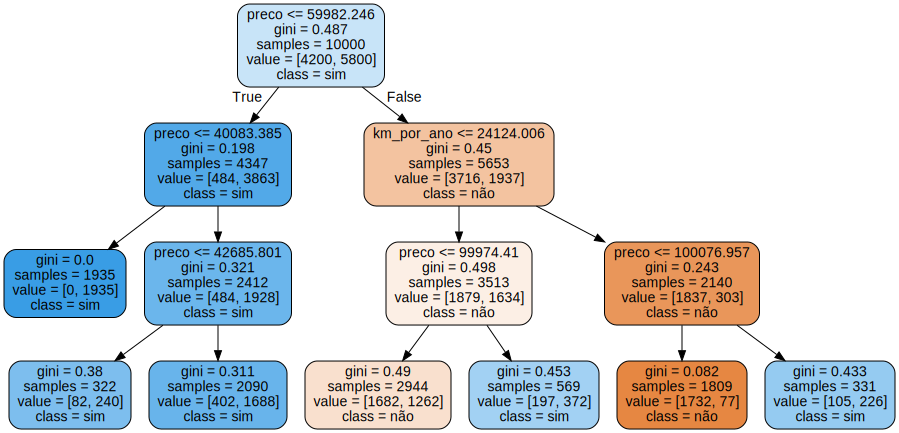

In [10]:
# O min_samples_leaf_não pareceu fazer muita diferença, certo?
print(train_test_score(max_depth=3, min_samples_leaf=300))
print(train_test_score(max_depth=3, min_samples_leaf=1))

# Visualizando a árvore com min_samples_leaf=1
features = x.columns
modelo = DecisionTreeClassifier(max_depth=3, min_samples_leaf=1).fit(x, y)
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                           feature_names=features, class_names=["não", "sim"])
arvore = graphviz.Source(dot_data)
display(arvore)

# Visualizando a árvore com min_samples_leaf=300
features = x.columns
modelo = DecisionTreeClassifier(max_depth=3, min_samples_leaf=300).fit(x, y)
dot_data = export_graphviz(modelo, out_file=None, filled=True, rounded=True, 
                           feature_names=features, class_names=["não", "sim"])
arvore = graphviz.Source(dot_data)
display(arvore)

Comentando sobre esse segundo parâmetro em específico:

Mesmo aumentando o número mínimo de samples para caracterizar uma escolha (uma folha) até 300, poucos deles foram modificados para a árvore com profundidade 3. Na aula, o instrutor passou esse parâmetro para analisar junto do max_depth mas, intuitivamente, esse parâmetro parece só ter influência em árvores com profundidade maior (no caso, 300 equivale a 3% do comprimento do dataset); seria uma forma de evitar que cada cartão focasse em um caso muito específico do conjunto de testes ao invés de generalizar como desejado.

# 03. Trabalhando com 3 ou mais dimensões

Há ainda mais parâmetros na documentação do DecisionTreeClassifier. Exemplificando pra mais um parâmetro numa varredura manual e para valores específicos antes de usar as funções de otimização:

In [11]:
# Mais uma vez, adicionando min_samples_split
max_depth = list(range(1, 31))
min_samples_leaf = np.multiply([0.01, 0.02, 0.04, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                               dados.shape[0]).astype(int)
min_samples_split = np.multiply([0.01, 0.02, 0.04, 0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
                               dados.shape[0]).astype(int)

scores = []

# Loop varrendo pelas 3 variáveis
for K in max_depth:
    for J in min_samples_leaf:
        for I in min_samples_split:
            score_K = list(train_test_score(K, J))
            aux = [K, J, I]
            aux.extend(score_K)
            scores.append(aux)
            # Lista com [max_depth, min_samples_leaf, min_samples_split, train_score, test_score]



In [12]:
# Organizando em um DataFrame            
score_df = pd.DataFrame(scores, columns=['max_depth', 'min_samples_leaf', 'min_samples_split', 
                                         'train_score',  'test_score'])
display(score_df.sort_values(by='test_score', ascending=False).head(10))

# Na matriz de correlação
corr = score_df.corr()

,max_depth,min_samples_leaf,min_samples_split,train_score,test_score
244,4,100,200,0.78755,0.7869
170,3,100,3000,0.78755,0.7869
177,3,200,2000,0.78755,0.7869
176,3,200,1500,0.78755,0.7869
175,3,200,1000,0.78755,0.7869
174,3,200,500,0.78755,0.7869
173,3,200,400,0.78755,0.7869
172,3,200,200,0.78755,0.7869
171,3,200,100,0.78755,0.7869
169,3,100,2500,0.78755,0.7869


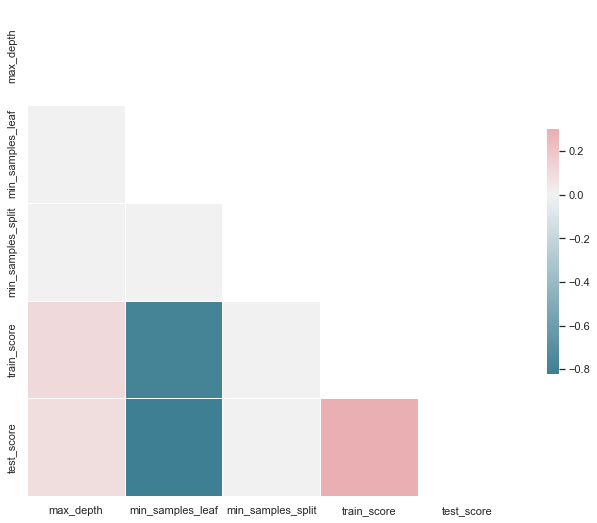

In [13]:
## Usando o código da página https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

# 04. Busca de parâmetros com o GridSearchCV

In [14]:
np.random.seed(333)

# Parâmetros a serem usados pelo gridsearchcv
espaco_de_parametros = {
    "max_depth" : list(range(2, 11)),
    "min_samples_split": np.multiply(list(range(1, 11)), dados.shape[0]/100).astype(int),
    "min_samples_leaf": np.multiply(list(range(1, 11)), dados.shape[0]/100).astype(int),
    "criterion": ["gini", "entropy"]
}

# Instanciando e ajustando 
busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv=KFold(n_splits=5, shuffle=True))
busca.fit(x, y)

GridSearchCV(cv=KFold(n_splits=5, random_state=None, shuffle=True),
             estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_leaf': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000]),
                         'min_samples_split': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])})

In [15]:
# Resultados
resultados = pd.DataFrame(busca.cv_results_)

# Informações da busca
melhores_params = busca.best_params_
melhor_score = busca.best_score_
melhor_estimador = busca.best_estimator_

print(f'Melhores parâmetros: {melhores_params}')
print(f'Melhor acurácia: {round(melhor_score*100, 2)}%')

Melhores parâmetros: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 100}
Melhor acurácia: 78.69%


# 05. Nested cross validation e validando o modelo escolhido

A escolha do modelo possui um viés associado, uma vez que a procura pelos hiperparâmetros que performam melhor pode trazer uma configuração final sobreajustada ao conjunto de dados, ou seja, hiperparâmetros feito sob medida para aquele dataset. Como dito na própria documentação do scikit-learn, a seleção de modelos sem validação cruzada aninhada acaba por utilizar os mesmos dados para refinar os parâmetros e avaliar a performance do modelo, fazendo com que informação 'vaze' no modelo e cause sobreajuste.

A técnica do nested cross validation busca eliminar esse problema e consiste em escolher de forma simultânea à otimização dos hiperparâmetros além de estimar o erro de generalização.

https://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf

https://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html

https://machinelearningmastery.com/nested-cross-validation-for-machine-learning-with-python/

In [16]:
%%time
np.random.seed(333)

# Na cross_val_score, usando o objeto do tipo GridSearchCV:
scores = cross_val_score(busca, x, y, cv=KFold(n_splits=5, shuffle=True))
scores

Wall time: 6min 57s


array([0.7795, 0.793 , 0.7755, 0.7805, 0.7815])

In [22]:
print(f'A acurácia obtida está em [{round((scores.mean()-2*scores.std())*100, 2)}%, {round((scores.mean()+ 2*scores.std())*100, 2)}%].')

A acurácia obtida está em [77.03%, 79.37%].
